Clone https://github.com/jfhealthcare/Chexpert and move CheXpert dataset inside this directory
Inference for 5 classes with pretrained weights

In [109]:
import torch
from easydict import EasyDict as edict
import json
from torch.nn import DataParallel
from model.classifier import Classifier
import time

# model = torch.load("config/pre_train.pth", map_location=torch.device('cpu'))

In [110]:
cfg_path = "config/example.json"
pre_train = "config/pre_train.pth"

with open(cfg_path) as f:
    cfg = edict(json.load(f))
    # print(json.dumps(cfg, indent=4))

# device_ids = list(map(int, args.device_ids.split(',')))
device_ids = []
num_devices = torch.cuda.device_count()
device = torch.device('cpu')
# device = torch.device('cuda:{}'.format(device_ids[0]))

classifier = Classifier(cfg)
model = DataParallel(classifier, device_ids=device_ids).to(device).train()
ckpt = torch.load(pre_train, map_location=device)
model.module.load_state_dict(ckpt)

<All keys matched successfully>

In [111]:
from torch.utils.data import DataLoader
from data.dataset import ImageDataset
import numpy as np

dataloader = DataLoader(
    ImageDataset(cfg["dev_csv"], cfg, mode='heatmap'),
    batch_size=1, num_workers=4,
    drop_last=False, shuffle=False)

In [112]:
torch.set_grad_enabled(False)
model.eval()
device = torch.device('cpu')
steps = len(dataloader)
dataiter = iter(dataloader)
num_tasks = len(cfg.num_classes)
txt_file = "plot.txt"

test_header = [
    'Path',
    'Cardiomegaly',
    'Edema',
    'Consolidation',
    'Atelectasis',
    'Pleural Effusion']

In [113]:
def get_pred(output, cfg):
    if cfg.criterion == 'BCE' or cfg.criterion == "FL":
        for num_class in cfg.num_classes:
            assert num_class == 1
        pred = torch.sigmoid(output.view(-1)).cpu().detach().numpy()
    elif cfg.criterion == 'CE':
        for num_class in cfg.num_classes:
            assert num_class >= 2
        prob = F.softmax(output)
        pred = prob[:, 1].cpu().detach().numpy()
    else:
        raise Exception('Unknown criterion : {}'.format(cfg.criterion))

    return pred

In [114]:
print(','.join(test_header) + '\n')
print("steps", steps, "num_tasks", num_tasks)
steps = 5
images = []

for step in range(steps):
    print("step ", step)
    image, path, labels = next(dataiter)
    image = image.to(device)
    output, __ = model(image)
    batch_size = len(path)
    pred = np.zeros((num_tasks, batch_size))

    for i in range(num_tasks):
        pred[i] = get_pred(output[i], cfg)

    for i in range(batch_size):
        batch = ','.join(map(lambda x: '{}'.format(x), pred[:, i]))
        result = path[i] + ',' + batch
        print(result + '\n')
        print('{}, Image : {}, Prob : {}, labels : {} '.format(
            time.strftime("%Y-%m-%d %H:%M:%S"), path[i], batch, labels))
        print('\n\n')
        images.append(path[i])
        

Path,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion

steps 234 num_tasks 5
step  0
CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg,0.6085793375968933,0.5058494210243225,0.2419632077217102,0.45605579018592834,0.12261803448200226

2022-10-01 16:57:02, Image : CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg, Prob : 0.6085793375968933,0.5058494210243225,0.2419632077217102,0.45605579018592834,0.12261803448200226, labels : tensor([[1., 0., 0., 0., 0.]]) 



step  1
CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg,0.05178125575184822,0.1388433873653412,0.17289796471595764,0.29364722967147827,0.08102937042713165

2022-10-01 16:57:02, Image : CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg, Prob : 0.05178125575184822,0.1388433873653412,0.17289796471595764,0.29364722967147827,0.08102937042713165, labels : tensor([[0., 0., 0., 0., 0.]]) 



step  2
CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg,0.223551

In [115]:
from util.heatmaper import Heatmaper 
# Heatmaper = None

disease_classes = [
    'Cardiomegaly',
    'Edema',
    'Consolidation',
    'Atelectasis',
    'Pleural Effusion'
]
plot_path = "plots"
alpha = 0.2
prefix = "none"

cfg["global_pool"] = "AVG_MAX"

# create plot folder
if not os.path.exists(plot_path):
    os.mkdir(plot_path)
# construct heatmap_cfg
heatmaper = Heatmaper(alpha, prefix, cfg, model, device)
assert prefix in ['none', *(disease_classes)]
with open(txt_file) as f:
    # for line in f:
    for line in images:
        time_start = time.time()
        jpg_file = line.strip('\n')
        print(jpg_file)
        prefix, figure_data = heatmaper.gen_heatmap(jpg_file)
        bn = os.path.basename(jpg_file)
        save_file = '{}/{}{}'.format(plot_path, prefix, bn)
        assert cv2.imwrite(save_file, figure_data), "write failed!"
        time_spent = time.time() - time_start
        print(
            '{}, {}, heatmap generated, Run Time : {:.2f} sec'
            .format(time.strftime("%Y-%m-%d %H:%M:%S"),
                    jpg_file, time_spent))

CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg
torch.Size([1, 3, 512, 512]) (320, 390, 3)
[tensor([[0.4413]]), tensor([[0.0234]]), tensor([[-1.1419]]), tensor([[-0.1762]]), tensor([[-1.9679]])] []


TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
import os
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
densenet = model.module.backbone

# forward hooks
t1, t2, t3 = [], [], []
t1_handle = densenet.features.transition1.conv.register_forward_hook(lambda module, in_tensor, out_tensor: t1.append(out_tensor))
t2_handle = densenet.features.transition1.conv.register_forward_hook(lambda module, in_tensor, out_tensor: t2.append(out_tensor))
t3_handle = densenet.features.transition1.conv.register_forward_hook(lambda module, in_tensor, out_tensor: t3.append(out_tensor))

# backward hooks
bt1, bt2, bt3 = [], [], []
bt1_handle = densenet.features.transition1.conv.register_backward_hook(lambda module, in_tensor, out_tensor: bt1.append(in_tensor))
bt2_handle = densenet.features.transition1.conv.register_backward_hook(lambda module, in_tensor, out_tensor: bt2.append(in_tensor))
bt3_handle = densenet.features.transition1.conv.register_backward_hook(lambda module, in_tensor, out_tensor: bt3.append(in_tensor))

In [ ]:
x = next(iter(dataloader))

torch.Size([1, 3, 512, 512])
('CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg',)


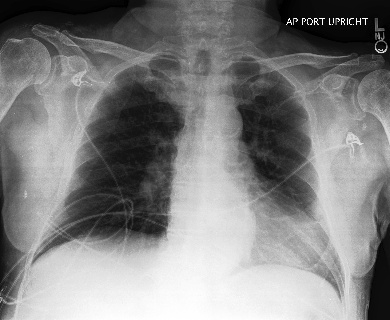

In [ ]:
print(x[0].shape)
print(x[1])
from IPython.display import Image
Image(filename=x[1][0]) 

In [ ]:
example = x[0][0:1]  # first example only (batch size = 1 so same)
out = model(example)
print(out)

([tensor([[0.4413]]), tensor([[0.0234]]), tensor([[-1.1419]]), tensor([[-0.1762]]), tensor([[-1.9679]])], [])


In [ ]:
def visualize(features):
    fig, axs = plt.subplots(len(features)//12,12,figsize=(2*12,2*len(features)//12))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(features[i].detach().abs())
        ax.axis('off')

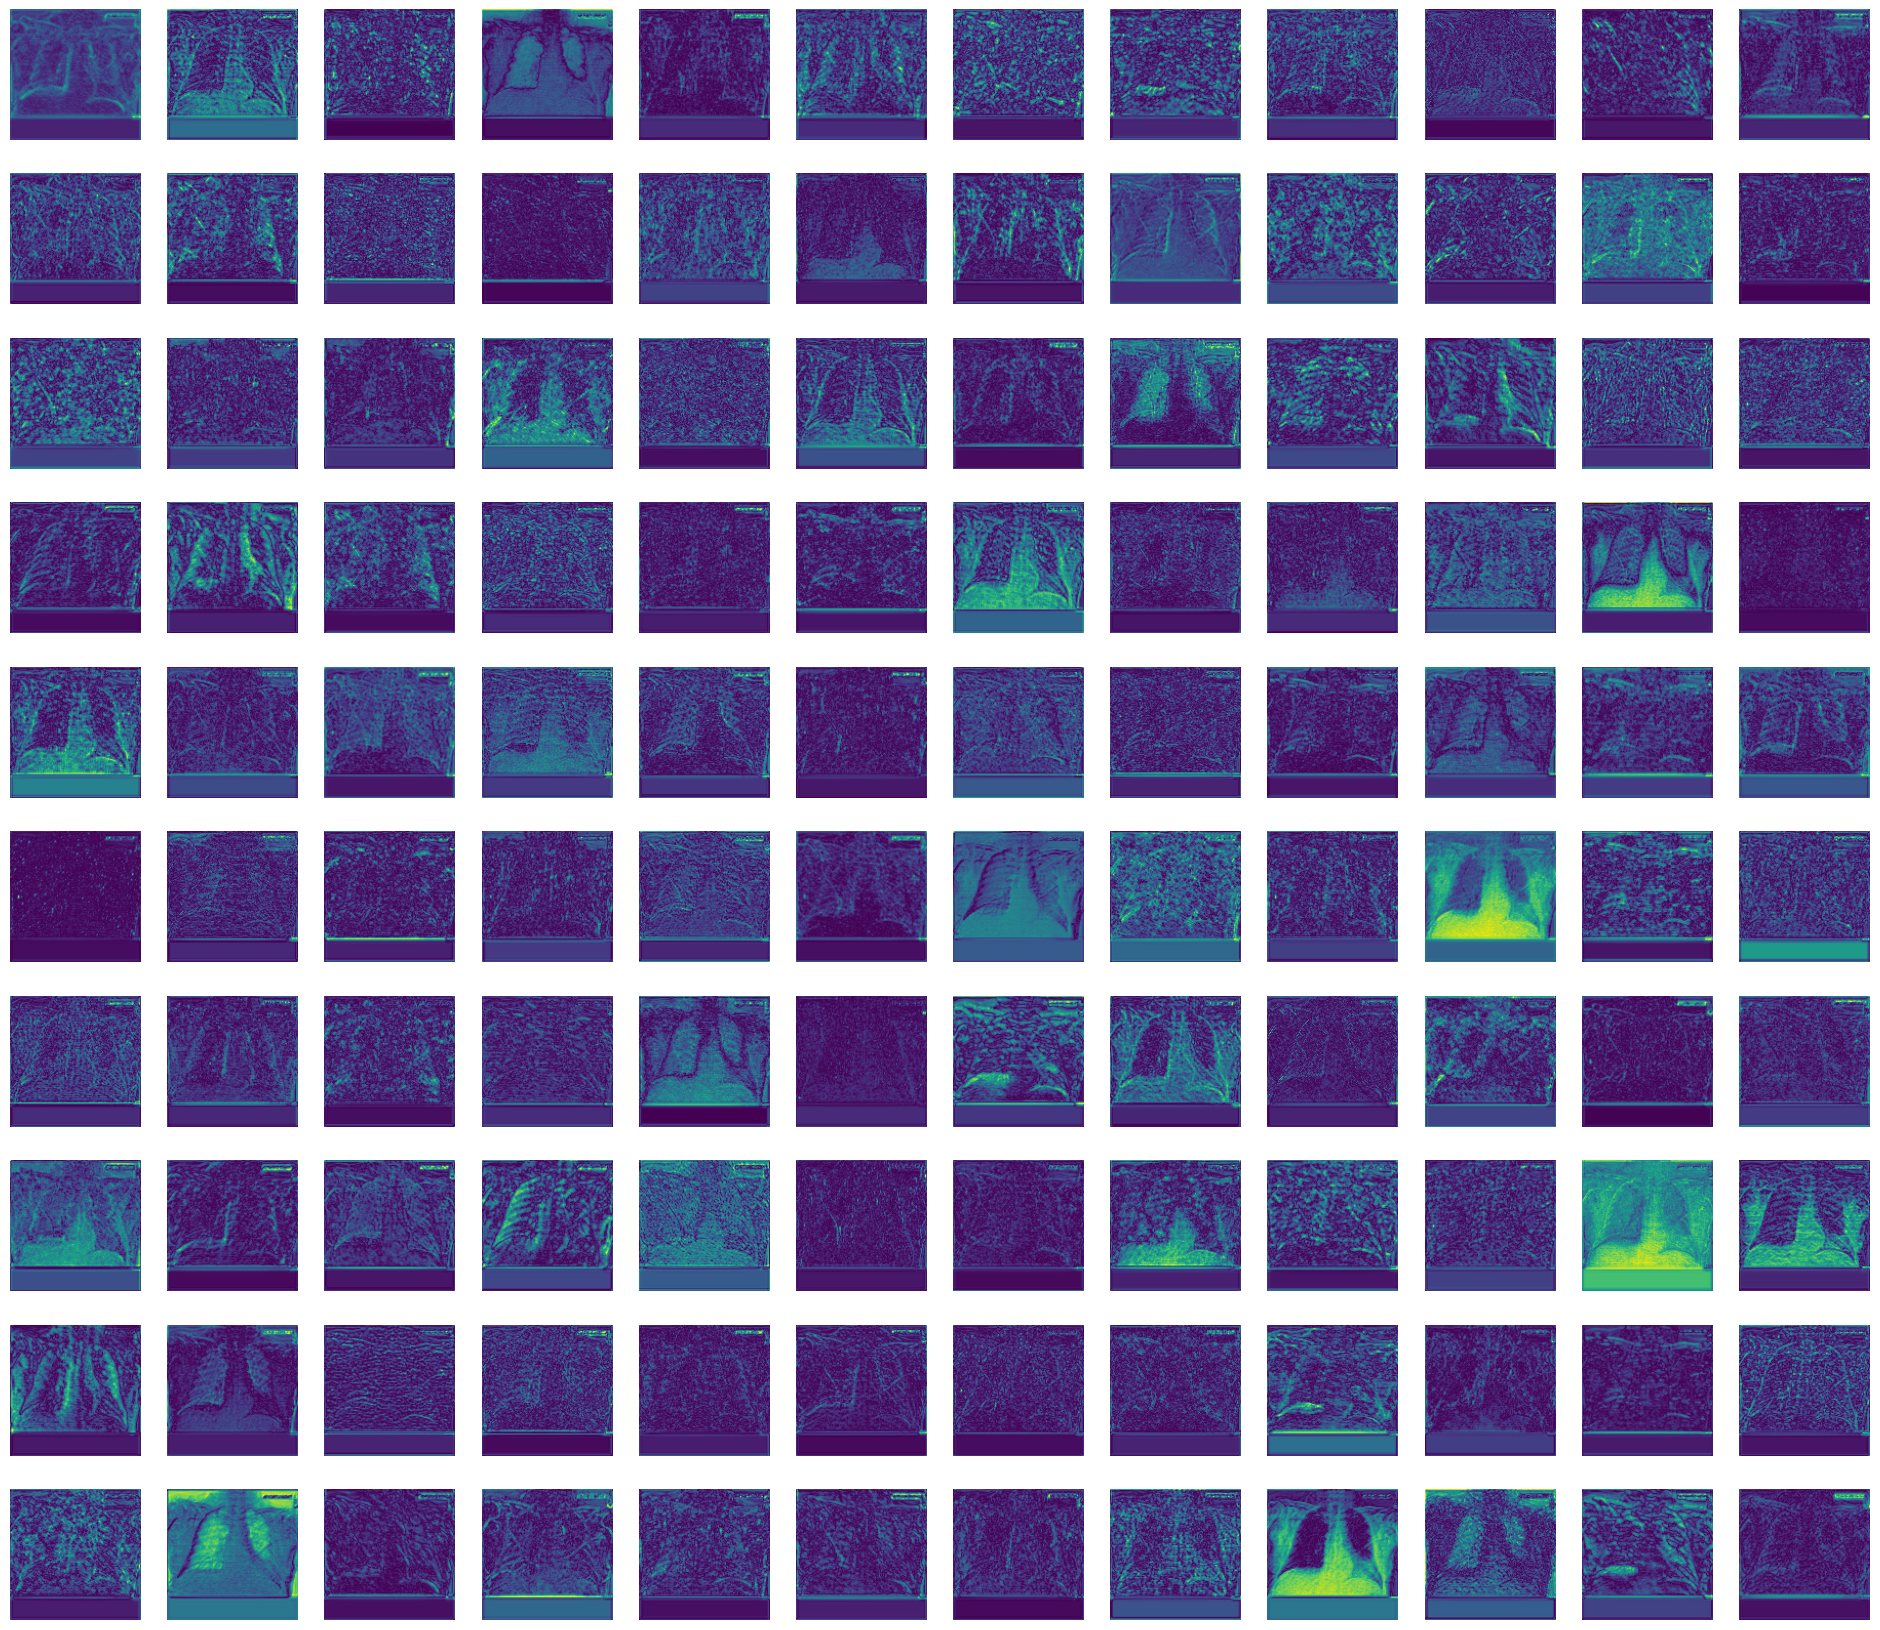

In [ ]:
visualize(t1[0][0])

torch.Size([1, 1024, 7, 7])
torch.return_types.max(
values=tensor([[[ 5.3062,  5.4640,  5.7011,  4.9649,  4.8080,  5.7341,  4.5758],
         [ 7.6767,  9.7983,  6.2510,  5.8336,  7.3408,  7.5524,  6.3017],
         [11.9636, 15.6451,  9.9112,  9.9745,  9.8814, 10.1704,  7.2354],
         [15.9082, 19.7167, 11.8732, 11.5404, 10.7497, 11.2894,  7.9989],
         [15.8258, 18.4220, 15.7649, 11.2058,  8.2978, 12.3869,  9.7019],
         [12.8814, 15.2949, 13.2623, 10.9130, 11.0957, 11.6733, 10.1905],
         [ 6.8659,  7.6023,  5.5024,  9.0950,  8.1581,  7.5557,  6.6488]]]),
indices=tensor([[[ 162,  780,  894,  894,  127,  698,  127],
         [1014, 1014, 1014, 1014,  886,  886,  698],
         [1014, 1014, 1014, 1014, 1014,  886,  886],
         [1014, 1014, 1014,  770, 1014, 1014, 1014],
         [1014, 1014,  770,  770, 1014, 1014, 1014],
         [1014,  770,  770,  908,  908, 1014, 1014],
         [ 770,  770,  770,  908,  908, 1014,  894]]]))
tensor([-4.1483, -7.9526,  0.1918, -0.

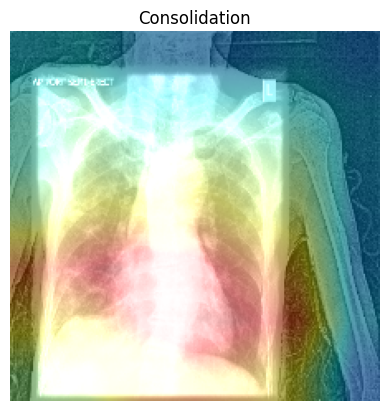

In [118]:
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

class HeatmapGenerator ():
 
    def __init__ (self, model, nnClassCount, transCrop):

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.backbone.features.parameters())[-2]

        #---- Initialize the image transform
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((transCrop, transCrop)))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)  
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            l = self.model.backbone(imageData)
            print(l.shape)
            output = self.model.backbone.features(imageData)
            print(torch.max(l, 1))

            logit_maps = list()
            logits = list()
            for index, num_class in enumerate(self.model.cfg.num_classes):
                # if self.model.cfg.attention_map != "None":
                #     feat_map = self.model.attention_map(l)

                classifier = getattr(self.model, "fc_" + str(index))
                # (N, 1, H, W)
                logit_map = None
                # (N, C, 1, 1)
                feat = self.model.global_pool(l, logit_map)

                if self.model.cfg.fc_bn:
                    bn = getattr(self.model, "bn_" + str(index))
                    feat = bn(feat)
                feat = F.dropout(feat, p=self.model.cfg.fc_drop, training=self.model.training)
                # (N, num_class, 1, 1)

                logit = classifier(feat)
                # (N, num_class)
                logit = logit.squeeze(-1).squeeze(-1)
                logits.append(logit)

            print(torch.tensor(logits))
            logits = torch.tensor(logits).reshape((1, -1))
            label = class_names[torch.max(logits, 1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(label)
        plt.imshow(img)
        plt.plot()
        plt.axis('off')
        plt.savefig(pathOutputFile)
        plt.show()

# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = 'CheXpert-v1.0-small/train.csv'
pathFileValid = 'CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
device = torch.device('cpu')

pathInputImage = 'CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg'
pathOutputImage = 'heatmap_view1_frontal.png'

h = HeatmapGenerator(classifier, nnClassCount, imgtransCrop)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)



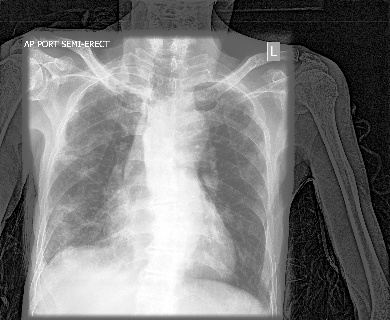

In [117]:
from IPython.display import Image
Image(filename=pathInputImage) 

In [ ]:
import pandas as pd

df = pd.read_csv("CheXpert-v1.0-small/valid.csv")